### Graph Neural Network for spatial data - node level regression

Spatial data can be conceptualized as a connected graph with nodes (locations) and edges (distances between nodes, connectivity).

So a regular spatial regression problem can be solved with GNN. Here we use the same house price data with nodes as individual properties, node level features include housing attributes, and edges as distances between properties.

PyTorch 's GNN modules need to be seperately installed as `pip install torch_geometric`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import numpy as np

Read the house price data

*Experiment with a larger fraction of the data.*

In [3]:
houses = pd.read_csv("https://raw.githubusercontent.com/Ziqi-Li/GIS5122/main/data/seattle_data_cleaned.csv")
sampled = houses.sample(frac=0.2,random_state=1)

Specify features, labels and coordinates. Coordinates will be used to build the graph.

Standardize your features and label

In [4]:
y = sampled.log_10_price.values.reshape(-1,1)

X = sampled[['bathrooms', 'sqft_living', 'sqft_lot', 'grade',
       'condition', 'waterfront', 'view', 'age']]

coordinates = sampled[['UTM_X', 'UTM_Y']].values

from sklearn.preprocessing import StandardScaler
# Scale the features

#Here we use a standard scaler that will make the data have mean of 0 and std of 1
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

y_scaled = scaler.fit_transform(y)

In [5]:
X_scaled.shape

(3316, 8)

### Build the graph

Next we build the graph. Note that it will be VERY costly to build a very large fully connected graph say, with more than 1,000 data points. So a compromise is to only add edges to nodes that are nearby within a certain `threshold_distance`. This can be a hyper-parameter to tune.

*Experiment with different threshold_distance values.*

In [6]:
%%time

from scipy.spatial import distance

# Get the number of properties as nodes
num_nodes = y.shape[0]

edges = []

threshold_distance = 1 #miles 

#Loop over all the pairs of nodes/locations
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        
        #Calculate distance between two nodes in the unit of mile
        dist = distance.euclidean(coordinates[i], coordinates[j])/1000/1.60934
        
        #Add an edge if the distance is below the threshold_distance
        if dist < threshold_distance:
            
            edges.append((i, j))
            edges.append((j, i))
            

#Make it a tensor
edges = torch.tensor(edges, dtype=torch.long).t().contiguous()

CPU times: user 13 s, sys: 99.5 ms, total: 13.1 s
Wall time: 13.2 s


In [7]:
#Your edges should have a shape of 2 by the number of edges.
edges.shape

torch.Size([2, 122542])

Next, by default, GNN convolutes neighboring nodes without any weights, this is fine for unweighted grapsh such as a social network, but for a spatial network, we usually want to impose the idea of distance as the weight of the edge.



In [8]:

def compute_edge_distances(x, edge_index):
    # Extract node features for each edge
    node_features_start = x[edge_index[0]]
    node_features_end = x[edge_index[1]]

    # Compute Euclidean distance between nodes for each edge
    distances = torch.sqrt(torch.sum((node_features_start - node_features_end) ** 2, dim=1))
    return distances

Also, we want to normalize the weight a bit for easier convergence. This is also the similar idea as in many spatial statistical models to use a weight based on distance-decay kernel  such as in KDE or GWR. Here, we use a Gaussian kernel. The degree of the decay can be controlled by the `sigma` parameter. Again, a hyper-parameter to tune.

*Experiment with different sigma values.*

In [9]:
def distance_to_weight(distances, sigma=1):
    # Convert distances to weights using a Gaussian kernel
    weights = torch.exp(- (distances ** 2) / (2 * sigma ** 2))
    return weights

### Train/Test split. 

This is a bit different for graph neurual networks compared to regular data becuase the sturcture of the data that we need to build the network based on the whole dataset. 

However, you can randomly mask part of the nodes in the graph  for test purpose.

In [10]:
#Shuffle node incides
indices = np.arange(num_nodes)
np.random.shuffle(indices)
split = int(num_nodes * 0.8)  # 80% of data for training

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

#Apply the mask
train_mask[indices[:split]] = True
test_mask[indices[split:]] = True

#Build the tensors
x = torch.tensor(X_scaled, dtype=torch.float)
y = torch.tensor(y_scaled, dtype=torch.float)

#calculate the edge distances and weights
distances = compute_edge_distances(x, edges)
weights = distance_to_weight(distances)

# Final data for GNN
data = Data(x=x,y=y, edge_index=edges,edge_attr=weights,
            train_mask=train_mask, test_mask=test_mask)

In [11]:
data

Data(x=[3316, 8], edge_index=[2, 122542], edge_attr=[122542], y=[3316, 1], train_mask=[3316], test_mask=[3316])

### Define the NN structure and layers

Here we use some convolutional layers followed to two fully connected layers. Again, this is just a demo, you can make it much more complicated or simpler.

*Experiment with different layer settings.*

In [12]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GraphConv,Linear

class GCNRegressor(torch.nn.Module):
    def __init__(self, num_node_features, output_size=1):
        super(GCNRegressor, self).__init__()
        
        # Two conv layers
        self.conv1 = GraphConv(num_node_features, 64)
        self.conv2 = GraphConv(64, 32)
        
        # Two fully-connected layers
        self.fc1 = Linear(32, 16)
        self.fc2 = Linear(16, 4)
        
        self.linear = Linear(4, output_size)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        #Feed forward your layers and apply Relu for hidden layer activation
        x = self.conv1(x, edge_index, edge_weight=edge_attr)
        x = F.relu(x)

        x = self.conv2(x, edge_index, edge_weight=edge_attr)
        x = F.relu(x)
        
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.relu(x)

        # Linear layer for regression
        x = self.linear(x)

        return x


In [13]:
# Initialize the model
model = GCNRegressor(num_node_features=X.shape[1])  # We have 8 housing features per node

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

loss_func = torch.nn.MSELoss()

In [14]:
%%time

train_losses = []
val_losses = []

for epoch in range(2000):  # Example epoch range
    model.train()
    optimizer.zero_grad()
    out = model(data)
    #Apply train_mask to get the training nodes
    loss = loss_func(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())  # Store training loss
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_out = model(data)
        
        #Apply train_mask to get the testing nodes
        val_loss = loss_func(out[test_mask], data.y[test_mask])
        val_losses.append(val_loss.item())  # Store validation loss
    

CPU times: user 6min 30s, sys: 4min 32s, total: 11min 2s
Wall time: 1min 6s


### Evaluate model performance

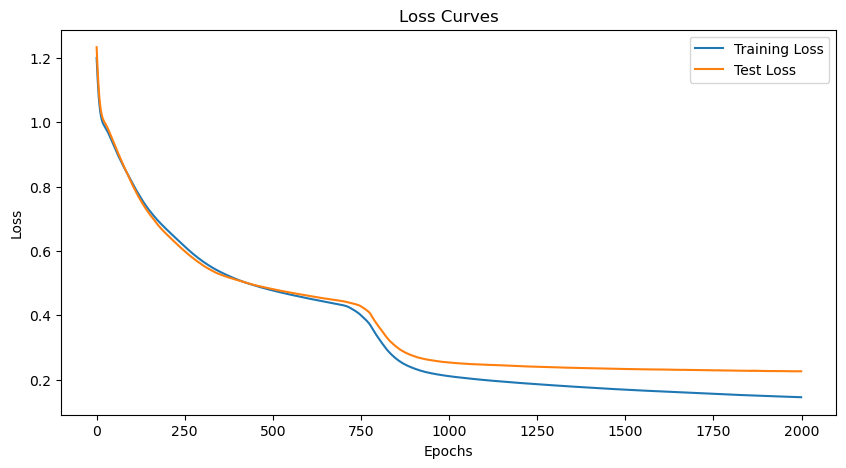

In [15]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Test Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')

#plt.ylim(0,1)
plt.legend()
plt.show()

In [16]:
from sklearn.metrics import r2_score

print("Model Train R2:",r2_score(data.y[train_mask].numpy(), val_out[train_mask].numpy()))
print("Model Test R2:",r2_score(data.y[test_mask].numpy(), val_out[test_mask].numpy()))

Model Train R2: 0.8546261277808451
Model Test R2: 0.772122813680529


In [17]:
y_pred = val_out[test_mask].numpy().reshape(-1,1)
y_true = data.y[test_mask].numpy().reshape(-1,1)

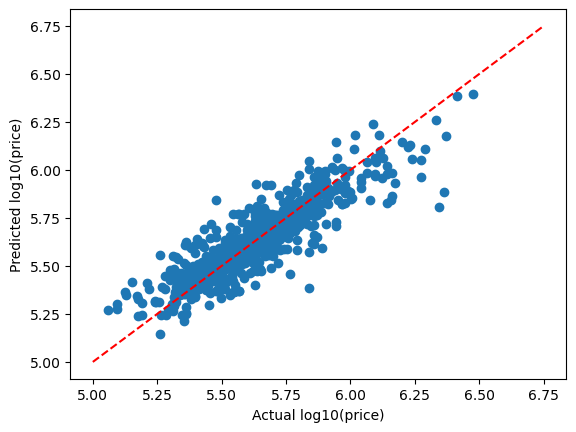

In [18]:

plt.scatter(scaler.inverse_transform(y_true), scaler.inverse_transform(y_pred))

plt.ylabel("Predicted log10(price)")
plt.xlabel("Actual log10(price)")
plt.plot([5,6.75],[5,6.75],'--',color='red')